In [1]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.datasets.utils import download_file_from_google_drive
from torch import optim, cuda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchsummary import summary
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image

In [3]:
file_id = "1NSLSDiSKmB2ALTnmeXn7MrJ_F-PZcz6b"
root = "/kaggle/working"
file_name = "vgg_cur_model_custom_cnn_2.pt"
download_file_from_google_drive(file_id, root, file_name)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 6)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 15 * 15, 480)
        self.fc2 = nn.Linear(480, 240)
        self.fc3 = nn.Linear(240, 29)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
index_to_char_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [18]:
image_transforms = transforms.Compose([
                        transforms.Resize((150, 150)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [7]:
#Parameters
dataset_1_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train' #Link: https://www.kaggle.com/grassknoted/asl-alphabet
dataset_2_dir = '../input/asl-alphabet-new-test/asl-alphabet-test' #Link: https://www.kaggle.com/yashudaykulkarni/asl-alphabet-new-test

img_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

save_file_name = '/kaggle/working/vgg_cur_model_custom_cnn_2.pt'

batch_size = 16
lr = 0.001
momentum = 0.9
epoch_stop_condition = 5
n_epochs = 5

dataset_1_length = 87000
dataset_2_length = 870

n_classes = 29

train_split_ratio = 0.5
val_split_ratio = 0.25

In [8]:
def load_model(model):
    device = torch.device('cpu')
    model.load_state_dict(torch.load(save_file_name, map_location=device))
    model.optimizer = optimizer

In [9]:
def get_predictions(img, model):

    probs = nn.Softmax(dim=1)
    
    img = img.unsqueeze(0)
    
    top5_classes = []
    
    with torch.no_grad():
        model.eval()

        output = model(img)
        softmax_output = probs(output)   
        
        top5_probs, top5_label = torch.topk(softmax_output, 5)
        
        top5_probs_list = top5_probs.cpu().flatten().tolist()
        top5_label_list = top5_label.cpu().flatten().tolist()
        
        for elem in top5_label_list:
            top5_classes.append(index_to_char_map[elem])
            
        return top5_probs_list, top5_classes

In [10]:
def get_random_classes(count):
    random_classes_list = []
    
    random_classes_list = random.sample(range(29), 5)
    
    return random_classes_list

In [11]:
def get_model():
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    return model, criterion, optimizer

In [12]:
model, criterion, optimizer = get_model()

In [13]:
load_model(model)

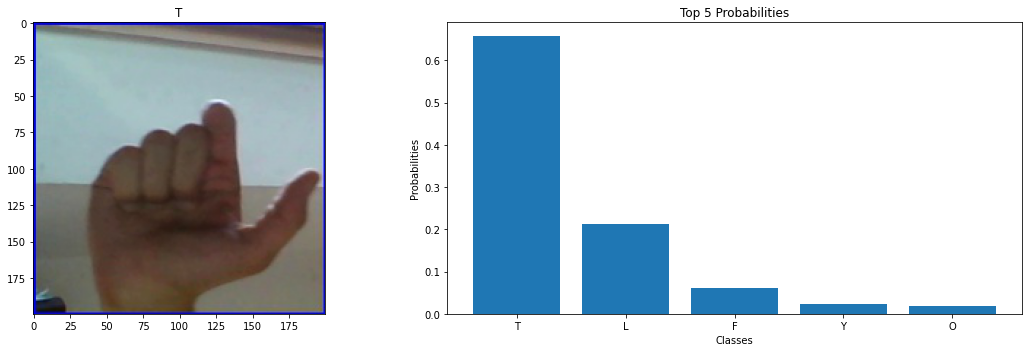

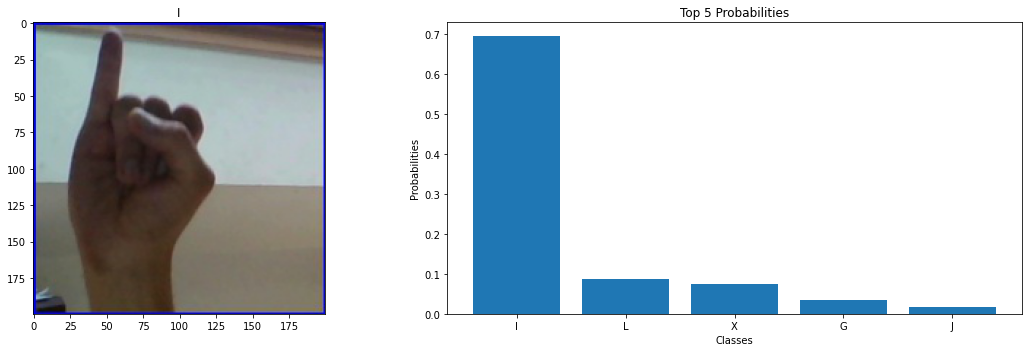

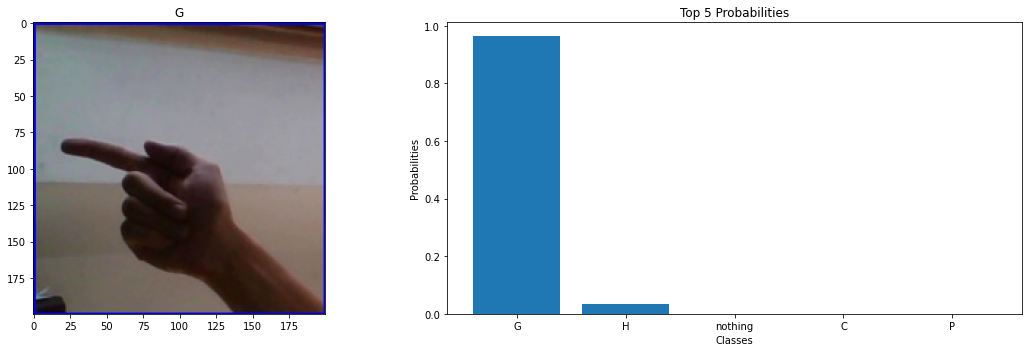

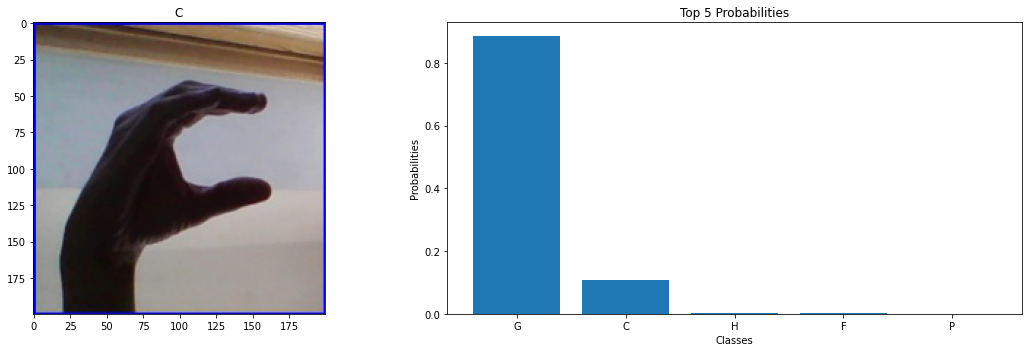

In [19]:
random_class_list = get_random_classes(5)

for value in random_class_list:
    value = index_to_char_map[value]
    if value != 'del':
        img = Image.open(img_dir + value + '_test.jpg')
        transformed_img = image_transforms(img)
        top5_prob, top5_label = get_predictions(transformed_img, model)
        
        plt.figure(figsize=(16, 5))
        
        ax = plt.subplot(1, 2, 1)
        ax.imshow(img)
        ax.set_title(value)
        
        ax = plt.subplot(1, 2, 2)
        ax.bar(top5_label, top5_prob)
        ax.set_title('Top 5 Probabilities')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probabilities')
        
        plt.tight_layout()
        
        plt.savefig(value + '_graph.png')